# Лабораторная работа №1

## Метод обратного распространения ошибки

Выполнила студентка группы 2238М1ПМкн1 Журилова Анастасия Сергеевна

Цель работы:

Реализовать метод обратного распространения ошибки для обучения глубоких нейронных сетей на примере двухслойной полностью связанной сети (один скрытый слой).

Задачи:

1) Загрузка данных

2) Визуализация данных

3) Предобработка данных

4) Реализация функций активации, потерь, точности

5) Реализация функций производных для формул изменения весов НС

6) Модель нейронной сети

* Реализация прямого хода метода обратного распространения ошибки

* Реализация обратного хода метода обратного распространения ошибки

7) Обучение модели

8) Применение модели на тестовых данных


Подключение необходимых библиотек

In [35]:
# Подключение библиотек
import numpy as np
import time

# Для загрузки данных
import os
from matplotlib import pyplot as plot
import torchvision.datasets
import torchvision.transforms

%matplotlib inline

### 1) Загрузка данных

In [ ]:
directory_name = os.getcwd()

# Тренировочные данные
train_dataset = torchvision.datasets.MNIST(
    root = directory_name, train = True, download = True,
    transform = torchvision.transforms.ToTensor()
)
# Тестовые данные
test_dataset = torchvision.datasets.MNIST(
    root = directory_name, train = False, download = True,
    transform = torchvision.transforms.ToTensor()
)

### 2) Визуализация данных

In [ ]:
# Размерность данных
print(f'Количество объектов в тренировочной выборке: {len(train_dataset)}')
print(f'Количество объектов в тестовой выборке: {len(test_dataset)}')
print()
print(f'Размерность изображения (X) = [{train_dataset.data.size()[1]}, {train_dataset.data.size()[2]}]')

Количество объектов в тренировочной выборке: 60000
Количество объектов в тестовой выборке: 10000

Размерность изображения (X) = [28, 28]


In [ ]:
# Показ изображений
def show_images(images, title):
    num_showed_imgs_x_figure = 8
    num_showed_imgs_y_figure = 2

    figsize = (8, 3)
    fig, axes = plot.subplots(num_showed_imgs_y_figure, num_showed_imgs_x_figure, figsize = figsize)
    fig.suptitle(title)
    plot.setp(plot.gcf().get_axes(), xticks = [], yticks = [])
    count = 0
    for i, ax in enumerate(axes.flat):
        img = images[i][0].numpy().transpose(1, 2, 0).squeeze(axis = 2)
        ax.set_title(images[i][1])
        ax.imshow(img, cmap = 'gray')

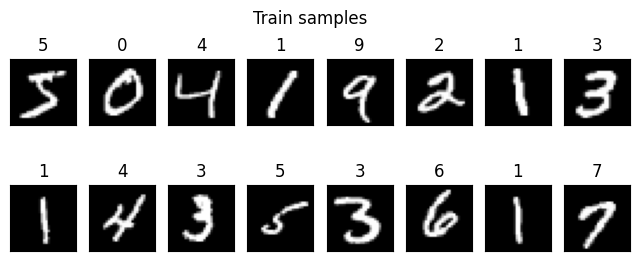

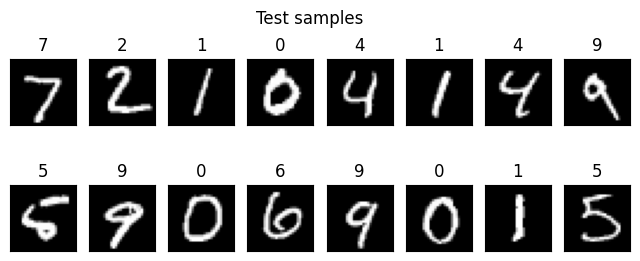

In [ ]:
# Результат загрузки:

show_images(train_dataset, 'Train samples')

show_images(test_dataset,'Test samples')

### 3) Предобработка данных

In [ ]:
image = train_dataset[0][0].numpy()[0]
print(f'image = {image}')
print(f'image Size = {image.shape}')

image = [[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.       

Изображения представлены в виде двумерного массива,
размерность которого 28x28. Перепишем массив пикселей в одну строку, т.е 1x784. Так будет проще работать с данными.

In [ ]:
image_one_line = image.reshape(1, image.shape[0]*image.shape[1])[0]
print(f'image_one_line = {image_one_line}')
print(f'image_one_line Size = {image_one_line.shape}')

image_one_line = [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.   

In [ ]:
# Проверка корректности составления
count = 0
for i in range(28):
  for j in range(28):
    if(image[i][j] == image_one_line[i*28 + j]):
      count += 1
    #print(f' {i}, {j}   image[i][j] = {image[i][j]}   image_one_line[i*28 + j] = {image_one_line[i*28 + j]}')
print(f'count = {count}')

count = 784


Данные Y представлены в виде int.
Лучше переделать в вектор вида [0, 0, 0, 0, 1, 0, 0, 0, 0, 0].
Где 1 стоит на той позиции, к какому классу пренадлежит изображение.

In [ ]:
label = train_dataset[0][1]
print(f'label = {label}')
label_probabilities = np.eye(10)[label]
print(f'label_probabilities = {label_probabilities}')

label = 5
label_probabilities = [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


Обработаем все данные:

In [ ]:
# Обрабатываем данные X  и Y тренировочной выборки
X_train = np.empty([len(train_dataset), train_dataset.data.size()[1] * train_dataset.data.size()[2]])
Y_train = np.empty([len(train_dataset), 10])

for line in range(len(train_dataset)):
  image_x = train_dataset[line][0].numpy()[0]
  image_x_one_line = image_x.reshape(1, image_x.shape[0]*image_x.shape[1])[0]
  X_train[line] = image_x_one_line

  class_y = np.eye(10)[train_dataset[line][1]]
  Y_train[line] = class_y
print(f'X_train[0] = {X_train[0]}')
print(f'X_train Sizes = {X_train.shape}')

print(f'Y_train[0] = {Y_train[0]}')
print(f'Y_train Sizes = {Y_train.shape}')

X_train[0] = [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.       

In [ ]:
# Обрабатываем данные X  и Y тестовой выборки
X_test = np.empty([len(test_dataset), test_dataset.data.size()[1] * test_dataset.data.size()[2]])
Y_test = np.empty([len(test_dataset), 10])

for line in range(len(test_dataset)):
  image_x = test_dataset[line][0].numpy()[0]
  image_x_one_line = image_x.reshape(1, image_x.shape[0]*image_x.shape[1])[0]
  X_test[line] = image_x_one_line

  class_y = np.eye(10)[test_dataset[line][1]]
  Y_test[line] = class_y
print(f'X_test[0] = {X_test[0]}')
print(f'X_test Sizes = {X_test.shape}')

print(f'Y_test[0] = {Y_test[0]}')
print(f'Y_test Sizes = {Y_test.shape}')

X_test[0] = [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        

### 4) Реализация функций активации, потерь, точности

In [ ]:
# Схема нейронной сети
# input_layer --> hidden_layer[sum_input_layer --> ReLu(sum_input_layer)] --> output_layer[sum_hidden_layer --> Softmax(sum_hidden_layer)] --> Loss_function(Cross-Entropy)

# Функции

# ReLu = { 0 : v_s <= 0; v : v_s > 0}
def ReLu(v):
  return np.maximum(v, 0)

# Softmax = e^{u_j} / (sum(i = 1...k) e^{u_i})
def Softmax(u):
  exp_u = np.exp(u)
  # сложение по строкам матрицы
  sum_exp_u = np.sum(exp_u, axis=1, keepdims=True)
  return (exp_u / sum_exp_u)

# Cross-Entropy
def Loss_Cross_Entropy(y, u):
  result = np.mean((- 1) * y * np.log(u))
  return result

# Точность
def Accuracy(y, u):
  u_max = np.argmax(u, axis = 1)
  y_max = np.argmax(y, axis = 1)
  return np.mean(u_max == y_max)

### 5) Реализация функций производных для формул изменения весов НС

In [ ]:
# Производные функции-активации и функции потерь

def ReLu_Derivative(v):
  return np.where(v > 0, 1, 0)

def Cross_Entropy_Derivative_With_Softmax(y, u):
  return (y - u)

### 6) Модель нейронной сети

In [ ]:
# Параметры
# Размер мини-пакета для реализации мини-пакетного стохастического градиентного спуска 8 - 64
batch_size = 64
# w * h
input_layer_size = 28 * 28
# k
output_layer_size = 10
# s
hidden_layer_size = 300
# Скорость обучения
learnig_rate = 0.1
# Количество эпох
epochs_count = 20

In [ ]:
class TwoLayerFullyConnectedNN():
  def __init__(self, input_layer_size, hidden_layer_size, output_layer_size, learning_rate, epochs_count):
    self.input_l_size = input_layer_size
    self.hidden_l_size = hidden_layer_size
    self.output_l_size = output_layer_size
    self.learnig_rate = learning_rate
    self.epochs_count = epochs_count
    # веса из нормального распределения N(0, 2/n_in)
    self.input_l_weights = np.random.normal(0, np.sqrt(2.0 / (input_layer_size)), size=(input_layer_size, hidden_layer_size))
    # внешнее воздействие на скрытый слой
    self.hidden_l_b = np.zeros((1, hidden_layer_size))
    # веса из нормального распределения N(0, 2/n_in)
    self.hidden_l_weights = np.random.normal(0, np.sqrt(2.0 / (input_layer_size)), size=(hidden_layer_size, output_layer_size))
    # внешнее воздействие на выходной слой
    self.output_l_b = np.zeros((1, output_layer_size))


  def forward(self, x):
    # V = X * W + B
    # vs = sum(i){xi*wsi + b0_i}
    self.v = np.dot(x, self.input_l_weights)
    self.v = self.v + self.hidden_l_b
    # V' = ReLu(v)
    self.v_activate = ReLu(self.v)
    # U = V * W + B
    # uj = sum(s){vs*wjs + b1_s}
    self.u = np.dot(self.v_activate, self.hidden_l_weights)
    self.u = self.u + self.output_l_b
    # U' = Softmax(u)
    self.u_activate = Softmax(self.u)


  def backward(self, x, y):
    coeff = (-1) * self.learnig_rate / batch_size

    #  delta w_js = nu/batch_size * Cross_Entropy_Der * vs
    der_wjs = Cross_Entropy_Derivative_With_Softmax(y, self.u_activate)
    delta_wjs = np.dot(self.v_activate.T, der_wjs)

    # delta b_j
    delta_output_l_b = np.sum(der_wjs, axis=0, keepdims=True)

    # delta w_si = nu/batch_size * Cross_Entropy_Der * ReLu' * xi
    der_wsi = np.dot(der_wjs, self.hidden_l_weights.T)
    der_ReLu = ReLu_Derivative(self.v)
    der_wsi = der_wsi * der_ReLu
    delta_wsi = np.dot(x.T, der_wsi)

    # delta b_s
    delta_hidden_l_b = np.sum(der_wsi, axis=0, keepdims=True)

    self.hidden_l_weights -= coeff * delta_wjs
    self.output_l_b -= coeff * delta_output_l_b
    self.input_l_weights -= coeff * delta_wsi
    self.hidden_l_b -= coeff * delta_hidden_l_b


  def Accuracy(self, y, x):
    self.forward(x)
    return Accuracy(y, self.u_activate)


  def train_model(self, x, y):
    print("Обучение:")
    print(' Эпохи:')
    for epoch in range(self.epochs_count):
      start_epoch_time = time.time()
      for batch in range(0, len(x), batch_size):
        x_batch = x[batch : batch + batch_size]
        y_batch = y[batch : batch + batch_size]

        self.forward(x_batch)

        self.backward(x_batch, y_batch)
      # Точность
      accuracy_epoch = self.Accuracy(y, x)
      # Время эпохи
      epoch_time = time.time() - start_epoch_time
      # Вывод информации
      print(f'   Эпоха[{epoch + 1}]:')
      print(f'      Точность = {(accuracy_epoch * 100):.6}%. Время = {epoch_time:.4}s')

### 7) Обучение модели

In [ ]:
modelBP = TwoLayerFullyConnectedNN(input_layer_size, hidden_layer_size, output_layer_size, learnig_rate, epochs_count)
modelBP

In [ ]:
modelBP.train_model(X_train, Y_train)

Обучение:
 Эпохи:
   Эпоха[1]:
      Точность = 92.8767%. Время = 5.959s
   Эпоха[2]:
      Точность = 95.2033%. Время = 4.691s
   Эпоха[3]:
      Точность = 96.405%. Время = 4.04s
   Эпоха[4]:
      Точность = 97.0783%. Время = 5.79s
   Эпоха[5]:
      Точность = 97.59%. Время = 4.129s
   Эпоха[6]:
      Точность = 97.965%. Время = 4.367s
   Эпоха[7]:
      Точность = 98.2433%. Время = 5.619s
   Эпоха[8]:
      Точность = 98.4383%. Время = 4.206s
   Эпоха[9]:
      Точность = 98.5933%. Время = 5.829s
   Эпоха[10]:
      Точность = 98.74%. Время = 4.754s
   Эпоха[11]:
      Точность = 98.8683%. Время = 4.191s
   Эпоха[12]:
      Точность = 98.96%. Время = 5.589s
   Эпоха[13]:
      Точность = 99.0383%. Время = 4.094s
   Эпоха[14]:
      Точность = 99.1383%. Время = 4.024s
   Эпоха[15]:
      Точность = 99.2367%. Время = 5.645s
   Эпоха[16]:
      Точность = 99.32%. Время = 3.993s
   Эпоха[17]:
      Точность = 99.38%. Время = 4.505s
   Эпоха[18]:
      Точность = 99.4283%. Время = 5.20

### 8) Применение модели на тестовых данных

In [ ]:
acc_test = modelBP.Accuracy(Y_test, X_test)
print(f'Тестовая выборка:')
print(f'  Точность = {(acc_test * 100):.6}%.')
print(f'  Ошибка = {((1 - acc_test) * 100):.6}%.')

Тестовая выборка:
  Точность = 97.83%.
  Ошибка = 2.17%.
